# Neironu tīkls "CNN Picking Flowers"
Šī neironu tīkla mērķis ir noteikt, kuri pikseļi pieder ziedam un izveidot atbilstošu masku ar kuru var izgriezt ziedu.

CNN ir izstrādāts ar Tensorflow bibliotēku. Šajā Python Notebook tiek izmantotas arī citas noderīgas bibliotēkas:
*   google.colab - Datu ielādei no Google Drive
*   Matplotlib - Diagrammu veidošanai un attēlošanai
*   Numpy - Tiek lietots kopā ar Tensorflow un Matplotlib
*   IPython - Izmanto funkcija, kas parāda treniņa progresu
*   typing - Funkciju definīcijām

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from IPython.display import clear_output
from typing import List
import numpy as np
import os

print("Tensorflow versija: " + tf.__version__)

Tensorflow versija: 2.4.0


# Datu ielāde
Datu kopa ir veidota no ziedu attēliem, kuriem ir norādīta CC0 license.

In [ ]:
# Mapju nosaukumi
MOUNT_DIR = "/content/drive"
DIR = MOUNT_DIR + "/MyDrive/dataset/"
DIR_PROCESSES = ["training/", "validation/"]
DIR_IMG_TYPES = ["images/", "annotations/"]

# Dati par attēlu kopu: dimensijas
IMAGE_SIZE = 128
N_CHANNELS = 3
N_CLASSES = 2

IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS)
MASK_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 1)

In [ ]:
# Piekļuve datiem
drive.mount(MOUNT_DIR)

In [ ]:
# Ielādē attēlu saturu
# Vārdnīcas ieraksti ir EagerTensor objekti
def parse_image(img_path: str) -> dict:
  # Ielādē attēlu no dotās adreses
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.uint8)

  # Uzģenerē adresi uz masku
  mask_path = tf.strings.regex_replace(img_path, DIR_IMG_TYPES[0], DIR_IMG_TYPES[1]) # nomaina 'images/' uz 'annotations/'
  mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")

  # Ielādē masku
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=1)
  mask = tf.where(mask >= N_CLASSES, np.dtype('uint8').type(1), mask)

  return {'image': image, 'segmentation_mask': mask}

In [ ]:
# Izveido datu kopu
train_data = tf.data.Dataset.list_files(DIR + DIR_IMG_TYPES[0] + DIR_PROCESSES[0] + "*.jpg")
train_data = train_data.map(parse_image)

val_data = tf.data.Dataset.list_files(DIR + DIR_IMG_TYPES[0] + DIR_PROCESSES[1] + "*.jpg")
val_data = val_data.map(parse_image)
dataset = {"train": train_data, "val": val_data}

Sagatavo datus treniņam:
*   Izgūst attēlu saturu un ievieto datu kopā
*   Normalizē attēlu RGB vērtības
*   One-hot iekodē segmentācijas maskas. Tas nozīmē, ka katrai krāsai maskā tiek piešķirta klase.


In [ ]:
# Konstantes par trenēšanu
BATCH_SIZE = 32
BUFFER_SIZE = 1000
SEED = 97

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# Funkcija, kas normalizē attēlu datus. RGB vērtības tiek konvertētas uz [0-1] intervāla vērtībām.
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMAGE_SIZE, IMAGE_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMAGE_SIZE, IMAGE_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
@tf.function
def load_image_test(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMAGE_SIZE, IMAGE_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMAGE_SIZE, IMAGE_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

dataset['train']

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

In [ ]:
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

dataset['val']

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

Datu priekšskatīšana

In [ ]:
def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

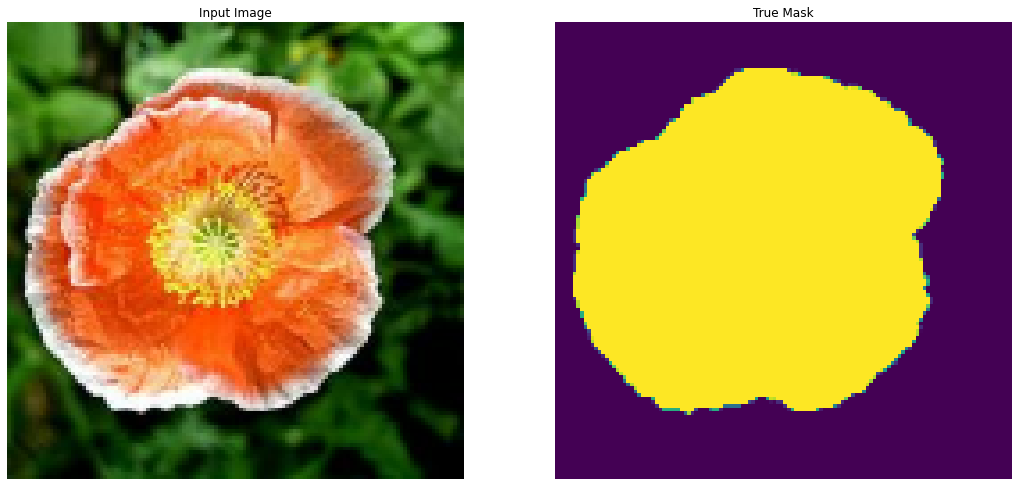

In [ ]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

# Modeļa definēšana

In [ ]:
input_size = [IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]]
OUTPUT_CHANNELS = N_CLASSES

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_size, include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# upsample funkcija no https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=input_size)
    x = inputs

  # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Var arī ielādēt saglabātos svarus no iepriekšējās modeļa trenēšanas reizes.

In [ ]:
checkpoint_path = "drive/MyDrive/training_2/cp.ckpt"
model.load_weights(checkpoint_path)

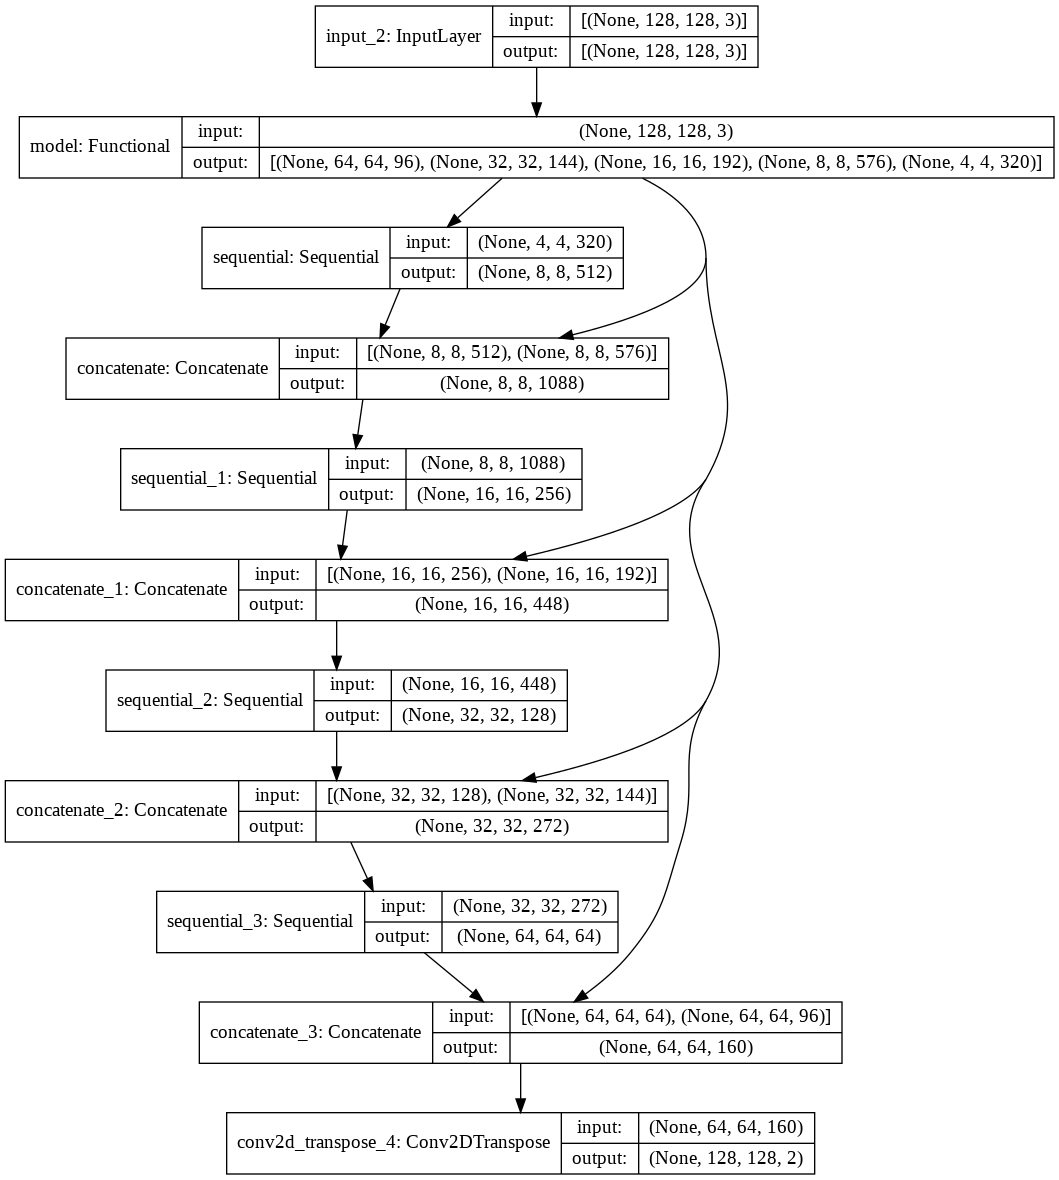

In [ ]:
# Uzzīmē modeļa uzbūvi
tf.keras.utils.plot_model(model, show_shapes=True)

Papildu funkcijas, lai varētu sekot līdzi modeļa treniņam.

In [ ]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    one_img_batch = sample_image[0][tf.newaxis, ...]
    inference = model.predict(one_img_batch)
    pred_mask = create_mask(inference)
    display_sample([sample_image[0], sample_mask[0],
                    pred_mask[0]])

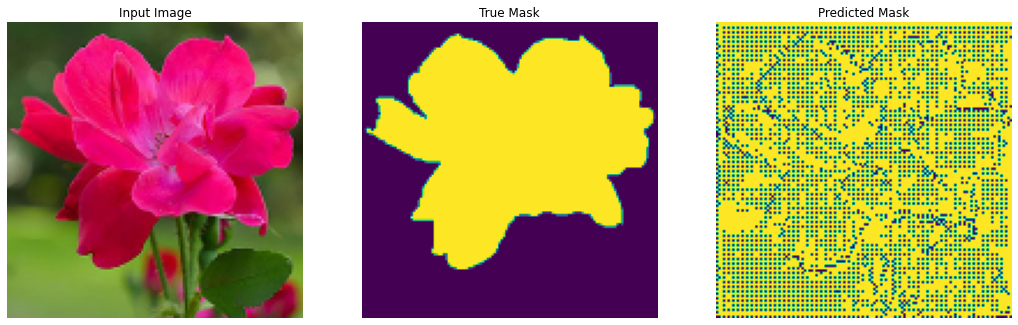

In [ ]:
show_predictions()

Modeļa treniņa tests. Šeit treniņš tiek palaists ar vienu evolūciju (kodā konstante EPOCHS), lai pārliecinātos, ka modelis pareizi strādā.

In [ ]:
#EPOCHS = 1
IMG_COUNT = 350
TEST_COUNT = 28


#VALIDATION_STEPS = TEST_COUNT // BATCH_SIZE

In [ ]:
#model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          #validation_data=dataset['val'])

Trenēšana

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
# Uztrenētā modeļa saglabāšanai.
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = IMG_COUNT//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = IMG_COUNT // BATCH_SIZE

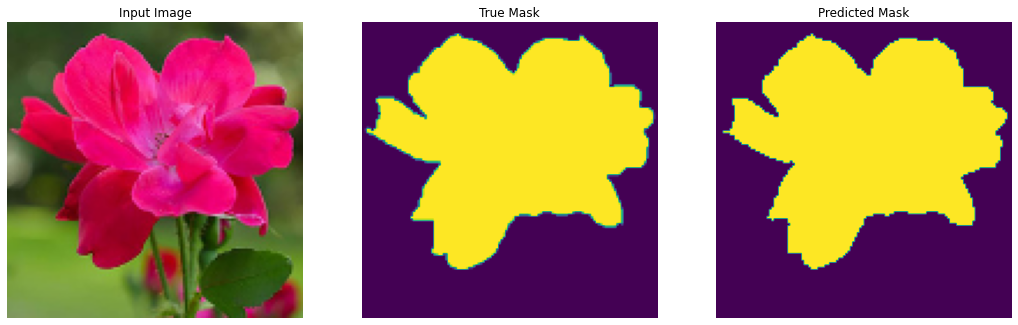


Sample Prediction after epoch 100


Epoch 00100: saving model to drive/MyDrive/training_2/cp.ckpt


In [ ]:
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'],
                          callbacks=[DisplayCallback(), cp_callback])

# Rezultāti
Diagrammās tiek apkopota informācija par modeļa precizitāti un zudumu katrā trenēšanas iterācijā.

In [ ]:
# Lielumi, kas tiks izmantoti abās diagrammās
epochs = range(EPOCHS)

figsize = (10,5)
x_major = np.arange(0, EPOCHS, 10)
x_minor = np.arange(0, EPOCHS, 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


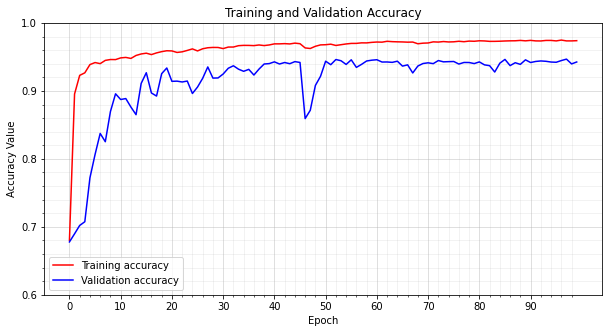

In [ ]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

fig_acc = plt.figure(figsize=figsize)
plt.plot(epochs, accuracy, '-r', label='Training accuracy')
plt.plot(epochs, val_accuracy, '-b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')

ax_acc = fig_acc.add_subplot(1, 1, 1)
ax_acc.set_xticks(x_major)
ax_acc.set_xticks(x_minor, minor=True)
ax_acc.set_yticks(np.arange(0.6, 1.01, 0.1))
ax_acc.set_yticks(np.arange(0.6, 1.01, 0.02), minor=True)

ax_acc.grid(which='both')
ax_acc.grid(which='minor', alpha=0.2)
ax_acc.grid(which='major', alpha=0.5)

#plt.grid()
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


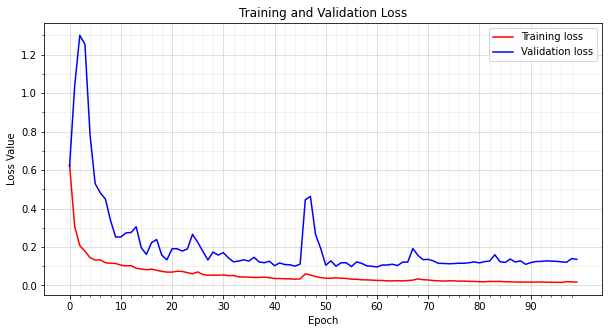

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

fig_loss = plt.figure(figsize=figsize)
plt.plot(epochs, loss, '-r', label='Training loss')
plt.plot(epochs, val_loss, '-b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')

ax_loss = fig_loss.add_subplot(1, 1, 1)

ax_loss.set_xticks(x_major)
ax_loss.set_xticks(x_minor, minor=True)
ax_loss.set_yticks(np.arange(0, 1.4, 0.2))
ax_loss.set_yticks(np.arange(0, 1.4, 0.1), minor=True)

ax_loss.grid(which='minor', alpha=0.2)
ax_loss.grid(which='major', alpha=0.5)

plt.legend()
plt.show()


In [ ]:
def remove_bg(image, mask):
  pass